## This notebook makes the figures in Figure 3C, and Supplemental Figures 9 and 10

In [1]:
# Loading required packages
library(reshape)
library(ggplot2)
library(phyloseq)
library(plyr)
library(dplyr)
library(plotly)
library(breakaway)
library(vegan)
library(ade4)
library(wesanderson)


Attaching package: ‘plyr’

The following objects are masked from ‘package:reshape’:

    rename, round_any


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:reshape’:

    rename

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘plotly’

The following objects are masked from ‘package:plyr’:

    arrange, mutate, rename, summarise

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:reshape’:

    rename

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: permute
Loading required package: lattice
This is vegan 2.4-4


In [29]:
ps = readRDS(file="CHTC/Dada2_Results_OA20_PEAR_Full/ps.fungi")

In [30]:
ps.norm = transform_sample_counts(ps, function(x) (x / sum(x)))
ps.norm
# Note, we are working with relative abundance-normalized data here,
# since the vegetation community matrix was created from a pct cover matrix (i.e., not Hellinger-transformed)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 5938 taxa and 101 samples ]
sample_data() Sample Data:       [ 101 samples by 103 sample variables ]
tax_table()   Taxonomy Table:    [ 5938 taxa by 16 taxonomic ranks ]

## Getting dist matrix

In [60]:
# Pulling out just O and just M horizon data separately
# We have to merge by Site ID to make the sample names match the vegetation matrix names (no O or M distinction)
ps.norm.org = prune_samples(sample_data(ps.norm)$Org_or_Min %in% c("O"), ps.norm)
ps.norm.min = prune_samples(sample_data(ps.norm)$Org_or_Min %in% c("M"), ps.norm)
ps.norm.org.merged = merge_samples(ps.norm.org, "Site_ID")
ps.norm.min.merged = merge_samples(ps.norm.min, "Site_ID")
ps.norm.org.merged.norm = transform_sample_counts(ps.norm.org.merged, function(x) x / sum(x) )
ps.norm.min.merged.norm = transform_sample_counts(ps.norm.min.merged, function(x) x / sum(x) )

# We also make a ps object with the full sample data
ps.merged = merge_samples(ps,"Sample_ID")
ps.merged.norm = transform_sample_counts(ps.merged, function(x) x/sum(x))

In [61]:
# Calculating distance matrices
Dist.org.fun = as.matrix(distance(ps.norm.org.merged.norm, method="bray", type="samples"))
Dist.min.fun = as.matrix(distance(ps.norm.min.merged.norm, method="bray", type="samples"))
Dist.fun = as.matrix(distance(ps.merged.norm, method="bray", type="samples"))

In [44]:
# Reading in the understory vegetation matrix
Dist.veg = read.csv("../../../../../../../Users/Thea/Documents/Madison/Box\ Sync/WhitmanLabMaster/WhitmanLab/Projects/WoodBuffalo/WB2015/data/Veg_properties/WBNPNWT_Vegetation_Braydistance_2015.csv")
row.names(Dist.veg)=Dist.veg$X
Dist.veg=Dist.veg[,2:dim(Dist.veg)[2]]
colnames(Dist.veg)=row.names(Dist.veg)

In [45]:
# Getting the organic and mineral fungal samples present in the plant matrix
OrgSamples = colnames(as.matrix(Dist.org.fun))[colnames(as.matrix(Dist.org.fun)) %in% colnames(as.matrix(Dist.veg))]
MinSamples = colnames(as.matrix(Dist.min.fun))[colnames(as.matrix(Dist.min.fun)) %in% colnames(as.matrix(Dist.veg))]

In [47]:
# Including only the taxa present in both matrices
Dist.org.veg = Dist.veg[row.names(Dist.veg) %in% OrgSamples,colnames(Dist.veg) %in% OrgSamples]
Dist.min.veg = Dist.veg[row.names(Dist.veg) %in% MinSamples,colnames(Dist.veg) %in% MinSamples]
Dist.org.fun = Dist.org.fun[row.names(Dist.org.fun) %in% OrgSamples,colnames(Dist.org.fun) %in% OrgSamples]
Dist.min.fun = Dist.min.fun[row.names(Dist.min.fun) %in% MinSamples,colnames(Dist.min.fun) %in% MinSamples]

In [49]:
# To check:
colnames(Dist.min.fun) == colnames(Dist.min.veg)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE

## Mantel tests

In [51]:
# Getting Site ID names of uplands and wetlands
Uplands = sample_data(ps)[sample_data(ps)$Land_Class=="Upland"]$Site_ID
Wetlands = sample_data(ps)[sample_data(ps)$Land_Class=="Wetland"]$Site_ID

In [52]:
# Putting together corresponding matrices for uplands/wetlands x organic/mineral horizons
Dist.org.veg.up =Dist.org.veg[row.names(Dist.org.veg) %in% Uplands ,colnames(Dist.org.veg) %in% Uplands]
Dist.min.veg.up =Dist.min.veg[row.names(Dist.min.veg) %in% Uplands ,colnames(Dist.min.veg) %in% Uplands]
Dist.org.fun.up =Dist.org.fun[row.names(Dist.org.fun) %in% Uplands ,colnames(Dist.org.fun) %in% Uplands]
Dist.min.fun.up =Dist.min.fun[row.names(Dist.min.fun) %in% Uplands ,colnames(Dist.min.fun) %in% Uplands]
Dist.org.veg.wet =Dist.org.veg[row.names(Dist.org.veg) %in% Wetlands ,colnames(Dist.org.veg) %in% Wetlands]
Dist.min.veg.wet =Dist.min.veg[row.names(Dist.min.veg) %in% Wetlands ,colnames(Dist.min.veg) %in% Wetlands]
Dist.org.fun.wet =Dist.org.fun[row.names(Dist.org.fun) %in% Wetlands ,colnames(Dist.org.fun) %in% Wetlands]
Dist.min.fun.wet =Dist.min.fun[row.names(Dist.min.fun) %in% Wetlands ,colnames(Dist.min.fun) %in% Wetlands]

In [53]:
#Running all Mantel tests
mantel.rtest(m1 = as.dist(Dist.org.veg.up), m2 = as.dist(Dist.org.fun.up), nrepet = 9999)
mantel.rtest(m1 = as.dist(Dist.org.veg.wet), m2 = as.dist(Dist.org.fun.wet), nrepet = 9999)
mantel.rtest(m1 = as.dist(Dist.min.veg.up), m2 = as.dist(Dist.min.fun.up), nrepet = 9999)
mantel.rtest(m1 = as.dist(Dist.min.veg.wet), m2 = as.dist(Dist.min.fun.wet), nrepet = 9999)

Monte-Carlo test
Call: mantelnoneuclid(m1 = m1, m2 = m2, nrepet = nrepet)

Observation: -0.01504688 

Based on 9999 replicates
Simulated p-value: 0.5612 
Alternative hypothesis: greater 

     Std.Obs  Expectation     Variance 
-0.177628318 -0.001092840  0.006171283 

Monte-Carlo test
Call: mantelnoneuclid(m1 = m1, m2 = m2, nrepet = nrepet)

Observation: 0.4301884 

Based on 9999 replicates
Simulated p-value: 1e-04 
Alternative hypothesis: greater 

      Std.Obs   Expectation      Variance 
 3.9275116918 -0.0008462656  0.0120445158 

Monte-Carlo test
Call: mantelnoneuclid(m1 = m1, m2 = m2, nrepet = nrepet)

Observation: 0.2331916 

Based on 9999 replicates
Simulated p-value: 0.0036 
Alternative hypothesis: greater 

      Std.Obs   Expectation      Variance 
 2.6992948729 -0.0005403809  0.0074978277 

Monte-Carlo test
Call: mantel.rtest(m1 = as.dist(Dist.min.veg.wet), m2 = as.dist(Dist.min.fun.wet), 
    nrepet = 9999)

Observation: -0.8976545 

Based on 9999 replicates
Simulated p-value: 0.8273 
Alternative hypothesis: greater 

    Std.Obs Expectation    Variance 
-1.24988960 -0.01040859  0.50390039 

## Plots

In [54]:
# Making a matrix with one data entry for each site
SamDat = sample_data(ps.norm)[!duplicated(sample_data(ps.norm)$Site_ID),]
rownames(SamDat) = SamDat$Site_ID

In [55]:
df = data.frame(melt(as.matrix(Dist.org.veg)),melt(as.matrix(Dist.org.fun)))
# Generates a dataframe with each contrast and the dissimilarity for the plant comm and the mb comm
# Can run with .org and with .min

df = df[,c(1,2,3,6)]
colnames(df) = c("Site_ID_1","Site_ID_2","Fun_dist","Veg_dist")

for (i in df$Site_ID_1){
    df$Land_Class_1[df$Site_ID_1==i] = paste(SamDat$Land_Class[SamDat$Site_ID==i])
}

head(df)

Site_ID_1,Site_ID_2,Fun_dist,Veg_dist,Land_Class_1
15S-NT-19,15S-NT-19,0.0000000,0.0000000,Wetland
15S-NT-20,15S-NT-19,0.7032652,0.9747800,Wetland
15S-NT-21,15S-NT-19,0.6677345,0.9586553,Wetland
15S-NT-22,15S-NT-19,0.9649712,0.7329424,Upland
15S-NT-23,15S-NT-19,1.0000000,0.9167678,Upland
15S-NT-24,15S-NT-19,0.9657845,0.7178454,Upland


In [56]:
df = data.frame(melt(as.matrix(Dist.org.veg)),melt(as.matrix(Dist.org.fun)))
# Generates a dataframe with each contrast and the dissimilarity for the plant comm and the mb comm
# Run with each different distance matrix

df = df[,c(1,2,3,6)]
colnames(df) = c("Site_ID_1","Site_ID_2","Fun_dist","Veg_dist")
#df$X1==df$X1.1 # making sure the contrasts are the same

# Need to add datasets for each site type, and then whether they are the same or not.
# Let's start with wetland vs. upland
for (i in paste(df$Site_ID_1)){
    df$Land_Class_1[df$Site_ID_1==i] = paste(SamDat$Land_Class[SamDat$Site_ID==i])
}
for (i in df$Site_ID_2){
    df$Land_Class_2[df$Site_ID_2==i] = paste(SamDat$Land_Class[SamDat$Site_ID==i])
}
df$Land_Class = ifelse(df$Land_Class_1==df$Land_Class_2,df$Land_Class_1,"Different")

# Let's add Veg_Comm
for (i in df$Site_ID_1){
    df$Veg_Comm_1[df$Site_ID_1==i] = paste(SamDat$Veg_Comm[SamDat$Site_ID==i])
}
for (i in df$Site_ID_2){
    df$Veg_Comm_2[df$Site_ID_2==i] = paste(SamDat$Veg_Comm[SamDat$Site_ID==i])
}
df$Veg_Comm = ifelse(df$Veg_Comm_1==df$Veg_Comm_2,df$Veg_Comm_1,"Different")

# Let's add Burned_Unburned
for (i in df$Site_ID_1){
    df$Burned_Unburned_1[df$Site_ID_1==i] = paste(SamDat$Burned_Unburned[SamDat$Site_ID==i])
}
for (i in df$Site_ID_2){
    df$Burned_Unburned_2[df$Site_ID_2==i] = paste(SamDat$Burned_Unburned[SamDat$Site_ID==i])
}
df$Burned_Unburned = ifelse(df$Burned_Unburned_1==df$Burned_Unburned_2,df$Burned_Unburned_1,"Different")

# And let's add Burn_Severity_Index
for (i in df$Site_ID_1){
    df$Burn_Severity_Index_1[df$Site_ID_1==i] = SamDat$Burn_Severity_Index[SamDat$Site_ID==i]
}
for (i in df$Site_ID_2){
    df$Burn_Severity_Index_2[df$Site_ID_2==i] = SamDat$Burn_Severity_Index[SamDat$Site_ID==i]
}
df$Burn_Severity_Index_1 = as.numeric(df$Burn_Severity_Index_1)
df$Burn_Severity_Index_2 = as.numeric(df$Burn_Severity_Index_2)
df$Burn_Severity_Index_Diff = abs(as.numeric(df$Burn_Severity_Index_1) - as.numeric(df$Burn_Severity_Index_2))
df$Burn_Severity_Index_Mean = (as.numeric(df$Burn_Severity_Index_1) + as.numeric(df$Burn_Severity_Index_2))/2
df$Burn_Severity_Index_Ratio = as.numeric(df$Burn_Severity_Index_1) / as.numeric(df$Burn_Severity_Index_2)
df$Burn_Severity_Index_Class = ifelse(df$Burn_Severity_Index_1>mean(df$Burn_Severity_Index_1) &
                                     df$Burn_Severity_Index_2>mean(df$Burn_Severity_Index_1),"high",
                                      ifelse(df$Burn_Severity_Index_1<mean(df$Burn_Severity_Index_1) &
                                     df$Burn_Severity_Index_2<mean(df$Burn_Severity_Index_1),"low","mixed"))
df$Burn_Severity_Index_Class = ordered(df$Burn_Severity_Index_Class, levels = c("high", "mixed", "low"))

# And let's add CBI
for (i in df$Site_ID_1){
    df$CBI_1[df$Site_ID_1==i] = SamDat$CBI[SamDat$Site_ID==i]
}
for (i in df$Site_ID_2){
    df$CBI_2[df$Site_ID_2==i] = SamDat$CBI[SamDat$Site_ID==i]
}
df$CBI_Diff = abs(as.numeric(df$CBI_1) - as.numeric(df$CBI_2))
df$CBI_Mean = (as.numeric(df$CBI_1) + as.numeric(df$CBI_2))/2

# And why not pH?
for (i in df$Site_ID_1){
    df$pH_1[df$Site_ID_1==i] = SamDat$pH[SamDat$Site_ID==i]
}
for (i in df$Site_ID_2){
    df$pH_2[df$Site_ID_2==i] = SamDat$pH[SamDat$Site_ID==i]
}
df$pH_Diff = abs(as.numeric(df$pH_1) - as.numeric(df$pH_2))
df$pH_Mean = (as.numeric(df$pH_1) + as.numeric(df$pH_2))/2

# And let's add Severity_Class
for (i in df$Site_ID_1){
    df$Severity_Class_1[df$Site_ID_1==i] = paste(SamDat$Severity_Class[SamDat$Site_ID==i])
}
for (i in df$Site_ID_2){
    df$Severity_Class_2[df$Site_ID_2==i] = paste(SamDat$Severity_Class[SamDat$Site_ID==i])
}
df$Severity_Class_2 = ordered(df$Severity_Class_2,levels=c("High", "Moderate", "Low"))
df$Severity_Class_1 = ordered(df$Severity_Class_1,levels=c("Low", "Moderate", "High"))
df$Severity_Class = ifelse(df$Severity_Class_1==df$Severity_Class_2,paste(df$Severity_Class_1),"Different")
df$Severity_Class = ordered(df$Severity_Class,levels=c("Low", "Moderate", "High","Different"))

### After making and saving dist matrices, can start here

In [57]:
#saveRDS(df,file="CHTC/Dada2_Results_OA20_PEAR_Full/DistMatrix.plant-fungi.O")
#saveRDS(df,file="CHTC/Dada2_Results_OA20_PEAR_Full/DistMatrix.plant-fungi.M")
df = readRDS(df,file="CHTC/Dada2_Results_OA20_PEAR_Full/DistMatrix.plant-fungi.O")
df = readRDS(df,file="CHTC/Dada2_Results_OA20_PEAR_Full/DistMatrix.plant-fungi.M")

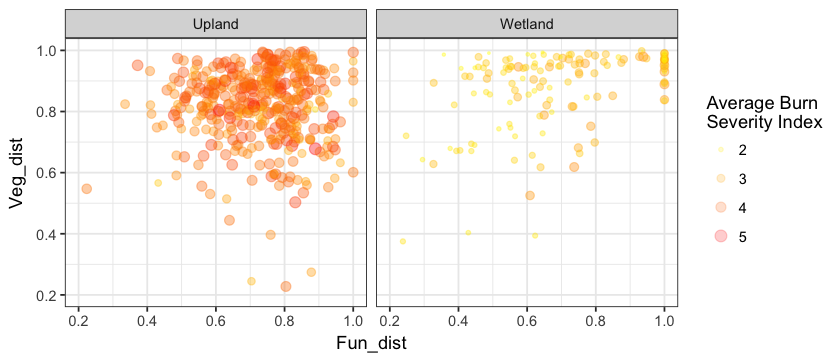

In [58]:
options(repr.plot.width=7, repr.plot.height=3)

df.no0 = df %>%
    filter(Site_ID_1 != Site_ID_2)%>%
    #filter(Veg_Comm != "Different")%>%
    filter(Land_Class!= "Different")

p = ggplot(df.no0 , aes(y=Veg_dist, x=Fun_dist, color=Burn_Severity_Index_Mean, size=Burn_Severity_Index_Mean))
p = p + geom_point(alpha=0.2) + scale_color_gradient(low="yellow",high="red")
p = p + facet_wrap(~Land_Class) 
p = p + scale_x_continuous(limits = c(0.2,1))
p = p + scale_y_continuous(limits = c(0.2,1))
p = p + scale_size(range=c(0,3))
#p = p + geom_abline(intercept=0, slope=1, linetype="dashed")
p = p + guides(color=guide_legend(title="Average Burn\nSeverity Index"),size=guide_legend(title="Average Burn\nSeverity Index"))
#p = p + geom_abline(intercept=0,slope=1, linetype=2)
p = p + theme_bw()
p

### What if we compare MB dist to only the baseline unburned sites and then plot by severity?

In [62]:
SamDat = sample_data(ps)
rownames(SamDat) = SamDat$Sample_ID
Dist.fun[upper.tri(Dist.fun)] = NA
df = data.frame(melt(Dist.fun))
#Generates a dataframe with each contrast and the dissimilarity for the mb comm
colnames(df) = c("Sample_ID_1","Sample_ID_2","Fun_dist")
df = df[df$Fun_dist!=0,]
df = df[!is.na(df$Fun_dist),]

In [63]:
# Need to add datasets for each site type, and then whether they are the same or not.
# Let's start with wetland vs. upland
for (i in df$Sample_ID_1){
    df$Land_Class_1[df$Sample_ID_1==i] = paste(SamDat$Land_Class[SamDat$Sample_ID==i])
}
for (i in df$Sample_ID_2){
    df$Land_Class_2[df$Sample_ID_2==i] = paste(SamDat$Land_Class[SamDat$Sample_ID==i])
}
df$Land_Class = ifelse(df$Land_Class_1==df$Land_Class_2,df$Land_Class_1,"Different")

# Let's add Veg_Comm
for (i in df$Sample_ID_1){
    df$Veg_Comm_1[df$Sample_ID_1==i] = paste(SamDat$Veg_Comm[SamDat$Sample_ID==i])
}
for (i in df$Sample_ID_2){
    df$Veg_Comm_2[df$Sample_ID_2==i] = paste(SamDat$Veg_Comm[SamDat$Sample_ID==i])
}
df$Veg_Comm = ifelse(df$Veg_Comm_1==df$Veg_Comm_2,df$Veg_Comm_1,"Different")

# Let's add Org_or_Min
for (i in df$Sample_ID_1){
    df$Org_or_Min_1[df$Sample_ID_1==i] = paste(SamDat$Org_or_Min[SamDat$Sample_ID==i])
}
for (i in df$Sample_ID_2){
    df$Org_or_Min_2[df$Sample_ID_2==i] = paste(SamDat$Org_or_Min[SamDat$Sample_ID==i])
}
df$Org_or_Min = ifelse(df$Org_or_Min_1==df$Org_or_Min_2,df$Org_or_Min_1,"Different")

# Let's add Burned_Unburned
for (i in df$Sample_ID_1){
    df$Burned_Unburned_1[df$Sample_ID_1==i] = paste(SamDat$Burned_Unburned[SamDat$Sample_ID==i])
}
for (i in df$Sample_ID_2){
    df$Burned_Unburned_2[df$Sample_ID_2==i] = paste(SamDat$Burned_Unburned[SamDat$Sample_ID==i])
}
df$Burned_Unburned = ifelse(df$Burned_Unburned_1==df$Burned_Unburned_2,df$Burned_Unburned_1,"Different")

# And let's add Burn_Severity_Index
for (i in df$Sample_ID_1){
    df$Burn_Severity_Index_1[df$Sample_ID_1==i] = SamDat$Burn_Severity_Index[SamDat$Sample_ID==i]
}
for (i in df$Sample_ID_2){
    df$Burn_Severity_Index_2[df$Sample_ID_2==i] = SamDat$Burn_Severity_Index[SamDat$Sample_ID==i]
}
df$Burn_Severity_Index_1 = as.numeric(df$Burn_Severity_Index_1)
df$Burn_Severity_Index_2 = as.numeric(df$Burn_Severity_Index_2)
df$Burn_Severity_Index_Diff = abs(as.numeric(df$Burn_Severity_Index_1) - as.numeric(df$Burn_Severity_Index_2))
df$Burn_Severity_Index_Mean = (as.numeric(df$Burn_Severity_Index_1) + as.numeric(df$Burn_Severity_Index_2))/2
df$Burn_Severity_Index_Ratio = as.numeric(df$Burn_Severity_Index_1) / as.numeric(df$Burn_Severity_Index_2)
df$Burn_Severity_Index_Class = ifelse(df$Burn_Severity_Index_1>mean(df$Burn_Severity_Index_1) &
                                     df$Burn_Severity_Index_2>mean(df$Burn_Severity_Index_1),"high",
                                      ifelse(df$Burn_Severity_Index_1<mean(df$Burn_Severity_Index_1) &
                                     df$Burn_Severity_Index_2<mean(df$Burn_Severity_Index_1),"low","mixed"))
df$Burn_Severity_Index_Class = ordered(df$Burn_Severity_Index_Class, levels = c("high", "mixed", "low"))

# And let's add CBI
for (i in df$Sample_ID_1){
    df$CBI_1[df$Sample_ID_1==i] = SamDat$CBI[SamDat$Sample_ID==i]
}
for (i in df$Sample_ID_2){
    df$CBI_2[df$Sample_ID_2==i] = SamDat$CBI[SamDat$Sample_ID==i]
}
df$CBI_Diff = abs(as.numeric(df$CBI_1) - as.numeric(df$CBI_2))
df$CBI_Mean = (as.numeric(df$CBI_1) + as.numeric(df$CBI_2))/2

# And let's add RBR
for (i in df$Sample_ID_1){
    df$RBR_1[df$Sample_ID_1==i] = SamDat$RBR[SamDat$Sample_ID==i]
}
for (i in df$Sample_ID_2){
    df$RBR_2[df$Sample_ID_2==i] = SamDat$RBR[SamDat$Sample_ID==i]
}
df$RBR_Diff = abs(as.numeric(df$RBR_1) - as.numeric(df$RBR_2))
df$RBR_Mean = (as.numeric(df$RBR_1) + as.numeric(df$RBR_2))/2


# And let's add Understory_CBI
for (i in df$Sample_ID_1){
    df$Understory_CBI_1[df$Sample_ID_1==i] = SamDat$Understory_CBI[SamDat$Sample_ID==i]
}
for (i in df$Sample_ID_2){
    df$Understory_CBI_2[df$Sample_ID_2==i] = SamDat$Understory_CBI[SamDat$Sample_ID==i]
}
df$Understory_CBI_Diff = abs(as.numeric(df$Understory_CBI_1) - as.numeric(df$Understory_CBI_2))
df$Understory_CBI_Mean = (as.numeric(df$Understory_CBI_1) + as.numeric(df$Understory_CBI_2))/2


# And why not pH?
for (i in df$Sample_ID_1){
    df$pH_1[df$Sample_ID_1==i] = SamDat$pH[SamDat$Sample_ID==i]
}
for (i in df$Sample_ID_2){
    df$pH_2[df$Sample_ID_2==i] = SamDat$pH[SamDat$Sample_ID==i]
}
df$pH_Diff = abs(as.numeric(df$pH_1) - as.numeric(df$pH_2))
df$pH_Mean = (as.numeric(df$pH_1) + as.numeric(df$pH_2))/2

# And let's add Severity_Class
for (i in df$Sample_ID_1){
    df$Severity_Class_1[df$Sample_ID_1==i] = paste(SamDat$Severity_Class[SamDat$Sample_ID==i])
}
for (i in df$Sample_ID_2){
    df$Severity_Class_2[df$Sample_ID_2==i] = paste(SamDat$Severity_Class[SamDat$Sample_ID==i])
}
df$Severity_Class_2 = ordered(df$Severity_Class_2,levels=c("High", "Moderate", "Low"))
df$Severity_Class_1 = ordered(df$Severity_Class_1,levels=c("Low", "Moderate", "High"))
df$Severity_Class = ifelse(df$Severity_Class_1==df$Severity_Class_2,paste(df$Severity_Class_1),"Different")
df$Severity_Class = ordered(df$Severity_Class,levels=c("Low", "Moderate", "High","Different"))

In [64]:
# Selecting only comparisons between unburned and burned sites
df = df[(df$Burned_Unburned_1=="Unburned" | df$Burned_Unburned_2=="Unburned"),]
df = df[df$Org_or_Min != "Different",]
df = df[df$Veg_Comm != "Different",]

[1] 224  40

In [66]:
# Is dissimilarity significantly related to burn severity index for wetlands? (no)
dfmod = df[df$Land_Class=="Wetland",]
lm = lm(Fun_dist~Burn_Severity_Index_Diff,data=dfmod)
summary(lm)


Call:
lm(formula = Fun_dist ~ Burn_Severity_Index_Diff, data = dfmod)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.18550 -0.06050  0.00952  0.07042  0.16273 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)               0.86411    0.03543  24.386   <2e-16 ***
Burn_Severity_Index_Diff -0.01498    0.02622  -0.571    0.571    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1002 on 40 degrees of freedom
Multiple R-squared:  0.008091,	Adjusted R-squared:  -0.01671 
F-statistic: 0.3263 on 1 and 40 DF,  p-value: 0.5711


In [65]:
# Is dissimilarity significantly related to burn severity index for uplands? (yes)
dfmod = df[df$Land_Class!="Wetland",]
lm = lm(Fun_dist~Burn_Severity_Index_Diff,data=dfmod)
summary(lm)


Call:
lm(formula = Fun_dist ~ Burn_Severity_Index_Diff, data = dfmod)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.33600 -0.03469  0.00984  0.05726  0.11313 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.834490   0.014172  58.884  < 2e-16 ***
Burn_Severity_Index_Diff 0.021728   0.005233   4.152 5.08e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07598 on 180 degrees of freedom
Multiple R-squared:  0.08741,	Adjusted R-squared:  0.08234 
F-statistic: 17.24 on 1 and 180 DF,  p-value: 5.075e-05


Warning message:
“Removed 1 rows containing missing values (geom_abline).”

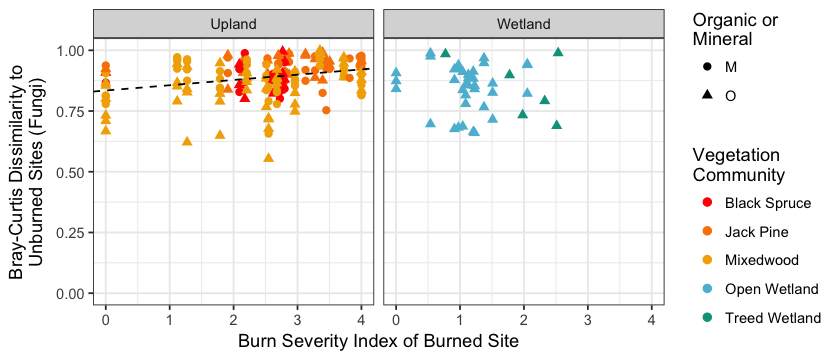

In [67]:
options(repr.plot.width=7, repr.plot.height=3)

p = ggplot(df,aes(x=Burn_Severity_Index_Diff,y=Fun_dist,color=Veg_Comm, shape=Org_or_Min))
p = p + geom_point(size=2)
p = p + scale_color_manual(values=wes_palette("Darjeeling")[c(1,4,3,5,2)])
p = p + scale_fill_manual(values=wes_palette("Darjeeling")[c(1,4,3,5,2)])
p = p + scale_shape_manual(values=c(16,17,23,25,15))

linedata = data.frame(Land_Class=c("Upland","Wetland"), slope=c(0.021728,NA), intercept=c(0.834490,NA))
p = p + geom_abline(data=linedata, aes(slope=slope,intercept=intercept),linetype=2)
p = p + ylim(values=c(0,1))
p = p + theme_bw()
p = p + facet_wrap(~Land_Class,ncol=2)
p = p + ylab("Bray-Curtis Dissimilarity to\nUnburned Sites (Fungi)") + xlab("Burn Severity Index of Burned Site")
p = p + guides(color=guide_legend(title="Vegetation\nCommunity"),shape=guide_legend(title="Organic or\nMineral"))
p